# Import Module and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
event_data = pd.read_csv('data/all_user_event_data.csv')
profile_data = pd.read_csv('data/all_user_profile_data.csv')
repo_data = pd.read_csv('data/all_user_repo_data.csv')
starred_data = pd.read_csv('data/all_user_starred_data.csv')

In [3]:
profile_data['followers'].fillna(0, inplace=True)
profile_data['following'].fillna(0, inplace=True)
profile_data['public_repos'].fillna(0, inplace=True)
profile_data['public_gists'].fillna(0, inplace=True)
profile_data['hireable'].fillna(False, inplace=True)

In [4]:
repo_data['stargazers_count'].fillna(0, inplace=True)
repo_data['forks'].fillna(0, inplace=True)
repo_data['fork'].fillna('False', inplace=True)

In [5]:
starred_data['stargazers_count'].fillna(0, inplace=True)

# Define Function

In [6]:
def regression_analysis(X, y):
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1)
    results = model.fit()
    return results

In [7]:
def select_numeric_column(df):
    return df.select_dtypes(include=[np.number])

In [8]:
def plot_corr(df, title):
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title(title)
    plt.show()
    return corr

In [9]:
def PlotPercentFreq(df, field, title, xlim):
    order = df[field].value_counts().index
    total = len(df)
    sns.barplot(y=df[field].value_counts().index, x=df[field].value_counts().values/total, order=order)
    plt.title(title)
    plt.xlim(0, xlim)
    plt.show()

In [10]:
def PlotTop10LanguagePercentage(df, title, xlim):
    language_counts = df.groupby(['user_alias', 'language']).size().unstack(fill_value=0)
    total_repos = df.groupby('user_alias').size()
    language_percentages = (language_counts.T / total_repos).T * 100
    overall_language_percentages = language_percentages.mean()
    top_10_languages = overall_language_percentages.nlargest(10).index
    top_10_language_percentages = language_percentages[top_10_languages]
    melted = top_10_language_percentages.reset_index().melt(id_vars='user_alias', var_name='language', value_name='percentage')
    average_percentages = melted.groupby('language')['percentage'].mean()
    top_10_languages = average_percentages.sort_values(ascending=False).head(10).index
    top_10_melted = melted[melted['language'].isin(top_10_languages)]
    sns.barplot(data=top_10_melted, y='language', x='percentage', order=top_10_languages, errorbar=None)
    plt.title(title)
    plt.xlim(0, xlim)
    plt.show()

In [11]:
def PlotScatter(df, field_x, field_y, field_type, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=field_x, y=field_y, hue=field_type, data=df)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

# Data Analysis

<b>Objective</b>: Get insights into the GitHub activity patterns of GitHub users with a high follower count.

The following steps will be undertaken to analyze the relationships:

<ul>
    <li>1. Determine if there are any disparities in the data fields between users with a high number of followers and those with fewer followers.</li>
    <li>2. If differences are found, conduct a detailed analysis to understand how these fields affect the number of followers and the nature of their influence.</li>
    <li>3. Visualize the data and perform statistical tests with a focus on significant values to better understand the patterns and trends.</li>
    <li>4. Repeat steps 1-3 for each data field.</li>
    <li>5. Compile and summarize the findings from each iteration.</li>
</ul>

## Selecting High-Follower User

In [12]:
 np.exp(4)

54.598150033144236

In [13]:
threshold = np.exp(4) # Reasons for choosing this threshold can be found in EDA notebook
high_follower_users = profile_data[profile_data['followers'] > threshold]

In [14]:
high_follower_users.head()

,user_alias,type,hireable,location,followers,following,public_repos,public_gists,created_at,updated_at
10,usr10,User,True,Ho Chi Minh City/Viet Nam,126.0,170.0,50.0,17.0,2015-05-07T09:55:21Z,2023-12-14T15:56:05Z
29,usr29,User,False,The Netherlands/Rotterdam,84.0,85.0,37.0,4.0,2011-03-18T17:11:58Z,2024-01-08T20:02:08Z
61,usr61,User,False,Belo Horizonte - MG/Brazil,226.0,102.0,50.0,0.0,2014-12-15T20:36:44Z,2023-12-14T12:24:33Z
82,usr82,User,True,Utah,128.0,6.0,110.0,59.0,2009-02-05T20:46:03Z,2024-01-09T16:56:59Z
88,usr88,User,False,Eindhoven/the Netherlands,70.0,0.0,10.0,0.0,2014-02-25T18:53:32Z,2024-01-12T10:08:54Z


In [15]:
len(high_follower_users)

342

In [16]:
high_follower_aliases = high_follower_users['user_alias']

In [17]:
high_follower_aliases.head()

10    usr10
29    usr29
61    usr61
82    usr82
88    usr88
Name: user_alias, dtype: object

In [18]:
high_follower_event_data = event_data[event_data['user_alias'].isin(high_follower_aliases)]
high_follower_repo_data = repo_data[repo_data['user_alias'].isin(high_follower_aliases)]
high_follower_starred_data = starred_data[starred_data['user_alias'].isin(high_follower_aliases)]

In [19]:
low_follower_users = profile_data[~profile_data['user_alias'].isin(high_follower_aliases)]
low_follower_event_data = event_data[~event_data['user_alias'].isin(high_follower_aliases)]
low_follower_repo_data = repo_data[~repo_data['user_alias'].isin(high_follower_aliases)]
low_follower_starred_data = starred_data[~starred_data['user_alias'].isin(high_follower_aliases)]

## Analyze The Relationship

### Profile Data

#### Correlation Analysis

In [20]:
profile_data.head()

,user_alias,type,hireable,location,followers,following,public_repos,public_gists,created_at,updated_at
0,usr0,User,False,NaN,2.0,7.0,43.0,0.0,2020-09-07T23:54:51Z,2023-10-05T18:16:01Z
1,usr1,User,False,Tbilisi,3.0,4.0,16.0,0.0,2011-04-16T12:30:37Z,2024-01-08T13:45:16Z
2,usr2,User,False,Karachi,13.0,23.0,44.0,0.0,2023-01-03T13:56:42Z,2023-12-24T05:10:36Z
3,usr3,User,True,Karachi,0.0,0.0,5.0,0.0,2021-09-24T09:04:40Z,2023-05-02T19:11:00Z
4,usr4,User,False,NaN,1.0,0.0,2.0,0.0,2022-10-07T11:01:08Z,2023-12-07T20:03:36Z


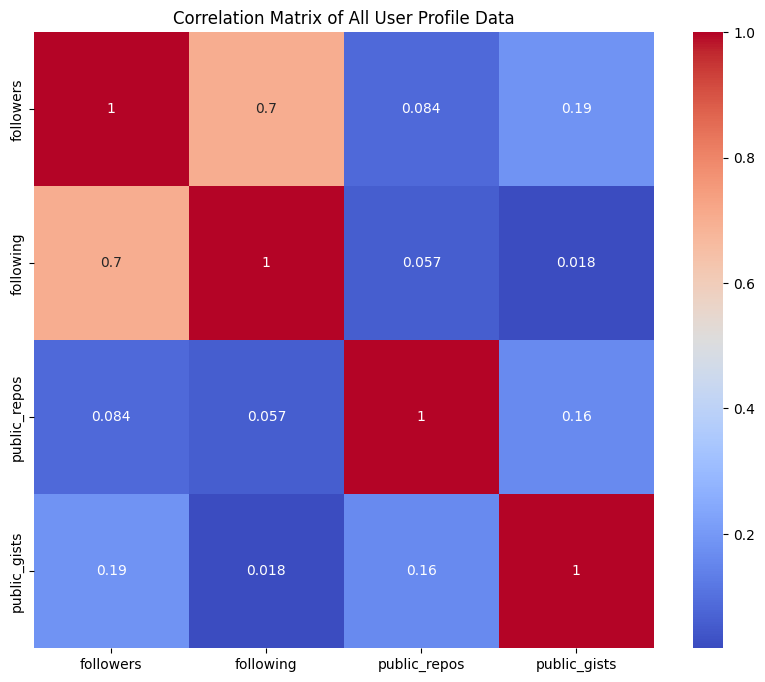

In [21]:
corr = plot_corr(select_numeric_column(profile_data), title='Correlation Matrix of All User Profile Data')

In [22]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.703030,0.084363,0.186087
following,0.703030,1.000000,0.056830,0.017962
public_repos,0.084363,0.056830,1.000000,0.161414
public_gists,0.186087,0.017962,0.161414,1.000000


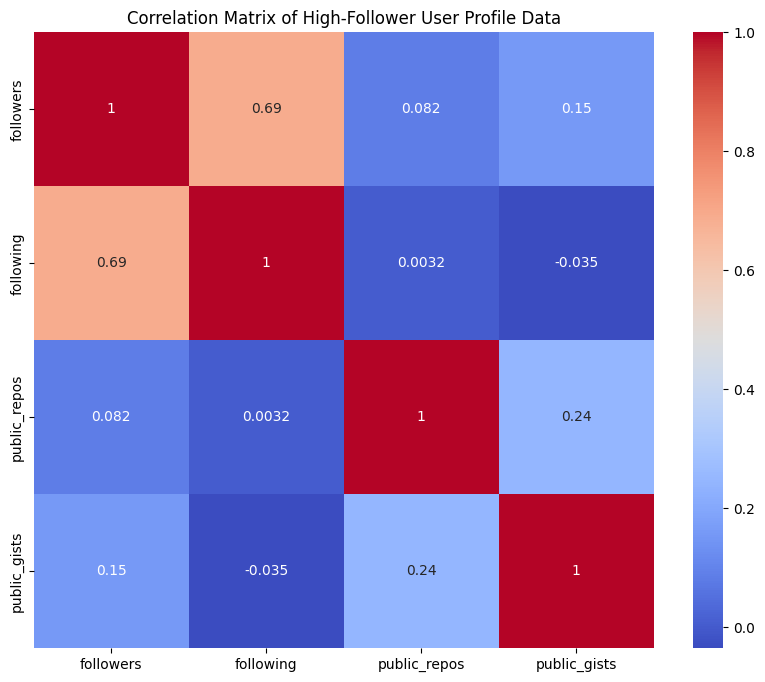

In [23]:
corr = plot_corr(select_numeric_column(high_follower_users), title='Correlation Matrix of High-Follower User Profile Data')

In [24]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.691971,0.082218,0.154670
following,0.691971,1.000000,0.003226,-0.035436
public_repos,0.082218,0.003226,1.000000,0.244570
public_gists,0.154670,-0.035436,0.244570,1.000000


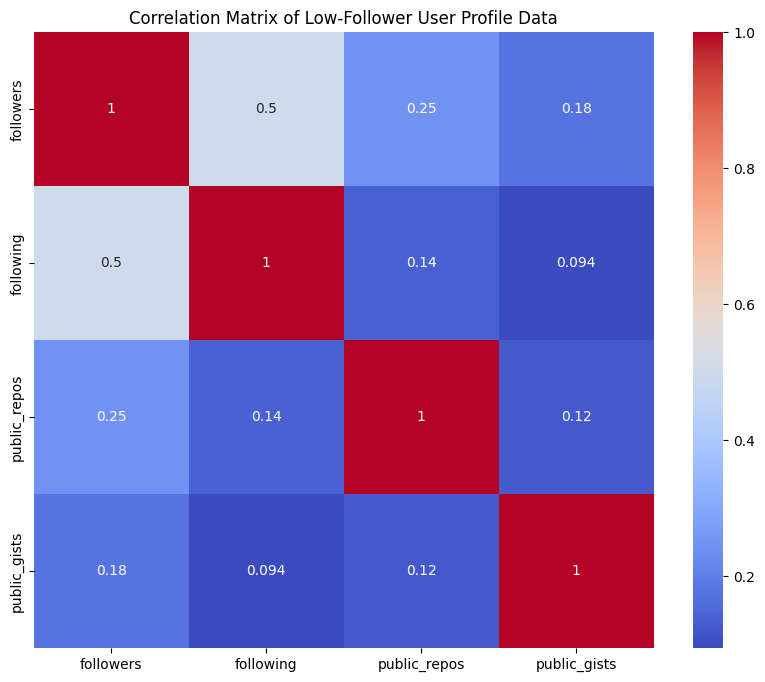

In [25]:
corr = plot_corr(select_numeric_column(low_follower_users), title='Correlation Matrix of Low-Follower User Profile Data')

In [26]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.503635,0.248180,0.176987
following,0.503635,1.000000,0.137273,0.093587
public_repos,0.248180,0.137273,1.000000,0.124815
public_gists,0.176987,0.093587,0.124815,1.000000


By analyzing the Correlation Matrix of each field in the profile data of all users and specifically high-follower users and observing a significant correlation between the `following` and `followers` fields. A correlation coefficient of 0.703030 and 0.691971 indicates a strong positive relationship, suggesting that as the number of users one follows increases, so does the number of followers they have.

#### Regression Analysis of `following` and `followers`

In [27]:
profile_data = profile_data.dropna(subset=['following', 'followers'])

In [28]:
results = regression_analysis(X = profile_data['following'], y = profile_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     8386.
Date:                Mon, 05 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:13:32   Log-Likelihood:                -55452.
No. Observations:                8583   AIC:                         1.109e+05
Df Residuals:                    8581   BIC:                         1.109e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8269      1.676      2.283      0.022       0.541       7.113
following      0.8114      0.009     91.575      0.000       0.794       0.829
==============================================================================
Omnibus:                    22845.898   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        898668767.498
Skew:                          31.610   Prob(JB):                         0.00
Kurtosis:                    1586.945   Cond. No.                         190.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
results.pvalues['following']

0.0

R-squared = 0.494, This is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variable. Meaning that approximately 49.3% of the variability in `followers` can be explained by `following`.

F-statistic = 8386, This is a measure of how significant the fit of the model is.

Prob (F-statistic) = 0.00 (The associated p-value) is less than 0.05 means that the independent variable, `following`, is a statistically significant predictor of `followers`.

coef for `following` = 0.8114, This is the change in the `followers` variable for a one-unit change in the `following` variable, holding all other variables constant. In this case, for each additional user that someone follows, their followers will increase by about 0.81.

### Event Data

#### Plot Percentage Of Event Frequency

In [30]:
event_data.head()

,user_alias,event_type,created_at
0,usr1,PushEvent,2023-10-31T17:57:39Z
1,usr1,CreateEvent,2023-10-30T18:13:26Z
2,usr1,CreateEvent,2023-10-30T17:53:32Z
3,usr2,CreateEvent,2024-01-08T17:29:08Z
4,usr2,CreateEvent,2024-01-08T17:27:38Z


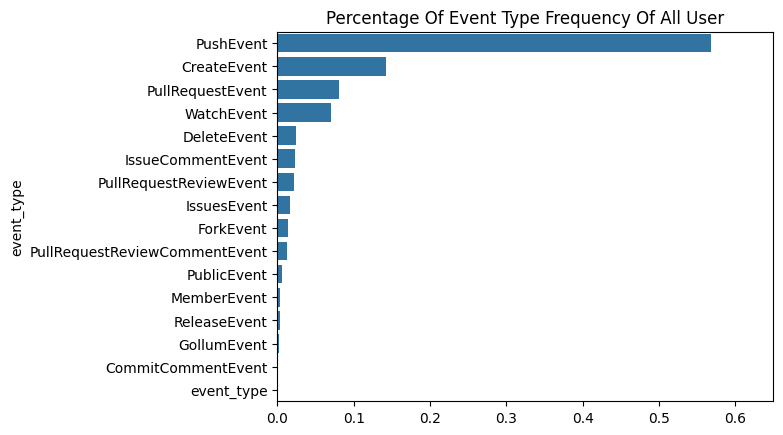

In [31]:
PlotPercentFreq(event_data, 'event_type', title='Percentage Of Event Type Frequency Of All User', xlim=0.65)

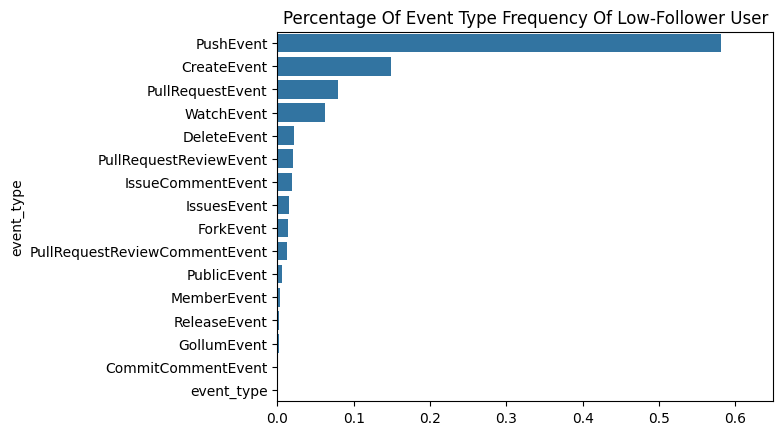

In [32]:
PlotPercentFreq(low_follower_event_data, 'event_type', title='Percentage Of Event Type Frequency Of Low-Follower User', xlim=0.65)

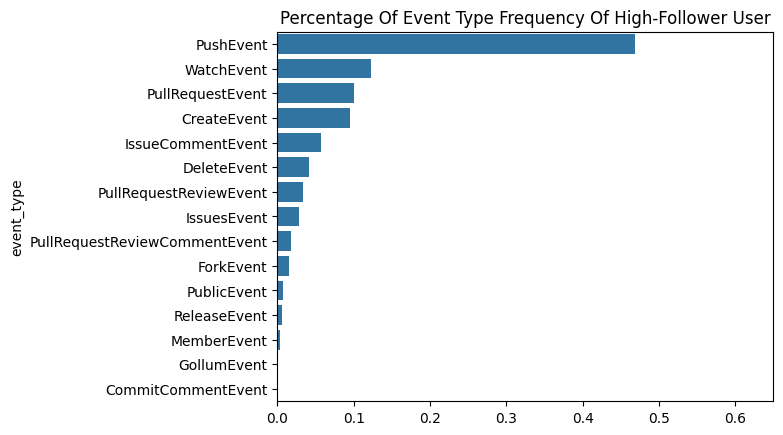

In [33]:
PlotPercentFreq(high_follower_event_data, 'event_type', title='Percentage Of Event Type Frequency Of High-Follower User', xlim=0.65)

These BarChart revealed a notable difference in the frequency of three specific event types: `PushEvent`, `CreateEvent` and `WatchEvent`.

`PushEvent` This could imply that high-follower users tend to push data to their GitHub repositories less frequently than low-follower users.

`CreateEvent` High-follower users have a lower frequency of CreateEvent compared to both low-follower users and the overall user base. This could imply that high-follower may not create new repositories as often as their low-follower counterparts.

`WatchEvent` High-follower users also have a higher frequency of WatchEvent. This indicates that they are more likely to watch or follow other users' repositories. This could be a reflection of their engagement with the GitHub community, keeping track of others' works and possibly gaining inspiration for their own projects.

#### Regression Analysis of `PushEvent`, `CreateEvent` and `WatchEvent` Frequency

In [34]:
event_counts = event_data.groupby(['user_alias', 'event_type']).size().unstack(fill_value=0)
event_counts.reset_index(inplace=True)

merged_data = pd.merge(profile_data[['user_alias', 'followers']], event_counts, on='user_alias')

In [35]:
merged_data.head()

,user_alias,followers,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PublicEvent,PullRequestEvent,PullRequestReviewCommentEvent,PullRequestReviewEvent,PushEvent,ReleaseEvent,WatchEvent,event_type
0,usr1,3.0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,usr2,13.0,1,27,0,0,0,0,0,1,0,0,0,0,8,0,0,0
2,usr5,0.0,0,6,0,0,0,0,1,0,0,0,0,0,4,0,1,0
3,usr6,1.0,0,8,1,0,0,1,1,2,2,1,0,0,220,1,2,0
4,usr8,0.0,0,6,0,0,0,0,0,0,0,0,0,0,8,0,0,0


In [36]:
y = merged_data['followers']

##### `PushEvent`

In [37]:
results = regression_analysis(X = merged_data['PushEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     23.49
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           1.30e-06
Time:                        20:13:33   Log-Likelihood:                -27835.
No. Observations:                4214   AIC:                         5.567e+04
Df Residuals:                    4212   BIC:                         5.569e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.1683      3.178      4.458      0.000       7.937      20.399
PushEvent      0.3073      0.063      4.847      0.000       0.183       0.432
==============================================================================
Omnibus:                    11648.633   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        351204565.992
Skew:                          34.761   Prob(JB):                         0.00
Kurtosis:                    1415.580   Cond. No.                         57.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
results.pvalues['PushEvent']

1.2980641781205548e-06

The p-value for `PushEvent` is 1.30e-06, which is less than 0.05. Therefore, the assumption that the amount of `PushEvent` have an effects on users' follower count is statistically supported.

for each additional `PushEvent` that someone makes, their followers will increase by about 0.31.

##### `CreateEvent`

In [39]:
results = regression_analysis(X = merged_data['CreateEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     20.47
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           6.24e-06
Time:                        20:13:33   Log-Likelihood:                -27837.
No. Observations:                4214   AIC:                         5.568e+04
Df Residuals:                    4212   BIC:                         5.569e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          13.6588      3.297      4.142      0.000       7.194      20.124
CreateEvent     1.3071      0.289      4.524      0.000       0.741       1.874
==============================================================================
Omnibus:                    11678.211   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        359644474.409
Skew:                          34.990   Prob(JB):                         0.00
Kurtosis:                    1432.471   Cond. No.                         13.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
results.pvalues['CreateEvent']

6.240264301547127e-06

The p-value for `CreateEvent` is 6.24e-06, which is also less than 0.05. Therefore, the assumption that the amount of `CreateEvent` have an effects on users' follower count is statistically supported.

for each additional `CreateEvent` that someone makes, their followers will increase by about 1.31.

##### `WatchEvent`

In [41]:
results = regression_analysis(X = merged_data['WatchEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     9.974
Date:                Mon, 05 Feb 2024   Prob (F-statistic):            0.00160
Time:                        20:13:33   Log-Likelihood:                -27842.
No. Observations:                4214   AIC:                         5.569e+04
Df Residuals:                    4212   BIC:                         5.570e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.6359      2.847      6.896      0.000      14.054      25.218
WatchEvent     0.7205      0.228      3.158      0.002       0.273       1.168
==============================================================================
Omnibus:                    11694.110   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        362359809.464
Skew:                          35.117   Prob(JB):                         0.00
Kurtosis:                    1437.857   Cond. No.                         12.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
results.pvalues['WatchEvent']

0.0015987978844532059

the p-value for `WatchEvent` is 0.00160, which is also less than 0.05. Therefore, the assumption that the amount of `WatchEvent` have an effects on users' follower count is statistically supported.

for each additional `WatchEvent` that someone makes, their followers will increase by about 0.72.

### Repo Data

In [43]:
repo_data.head()

,user_alias,description,fork,stargazers_count,language,topics,forks
0,usr0,NaN,False,0.0,JavaScript,NaN,0.0
1,usr0,NaN,False,0.0,JavaScript,NaN,0.0
2,usr0,NaN,False,0.0,JavaScript,NaN,0.0
3,usr0,NaN,False,0.0,JavaScript,NaN,0.0
4,usr0,NaN,False,0.0,JavaScript,NaN,0.0


### Analyzing the correlation between providing repository descriptions and topics, and the follower count for all users.

In [44]:
all_users_percentages = repo_data.groupby('user_alias')[['description', 'topics']].apply(lambda x: x.notna().mean() * 100)

In [45]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], all_users_percentages, on='user_alias')

In [46]:
merged_data['user_type'] = ['high-follower user' if x > threshold else 'low-follower user' for x in merged_data['followers']]

In [47]:
merged_data.head()

,user_alias,followers,description,topics,user_type
0,usr0,2.0,46.511628,0.0,low-follower user
1,usr1,3.0,56.250000,0.0,low-follower user
2,usr2,13.0,13.043478,0.0,low-follower user
3,usr3,0.0,100.000000,40.0,low-follower user
4,usr4,1.0,0.000000,0.0,low-follower user


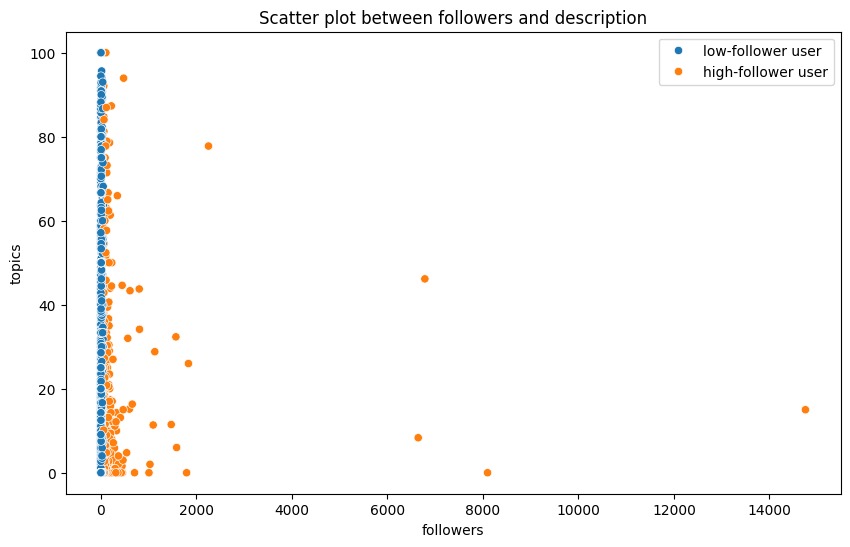

In [48]:
PlotScatter(df = merged_data, field_x = 'followers', field_y = 'topics', field_type = 'user_type', title = 'Scatter plot between followers and description')

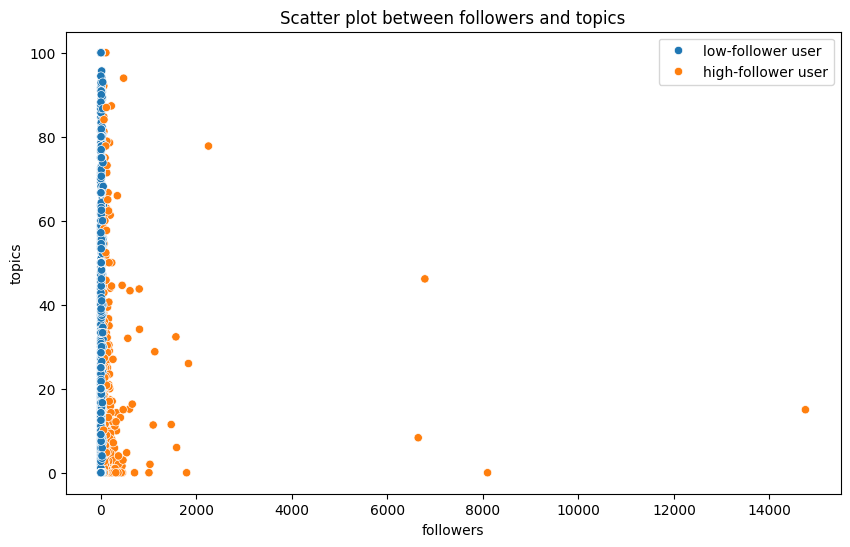

In [49]:
PlotScatter(df = merged_data, field_x = 'followers', field_y = 'topics', field_type = 'user_type', title = 'Scatter plot between followers and topics')

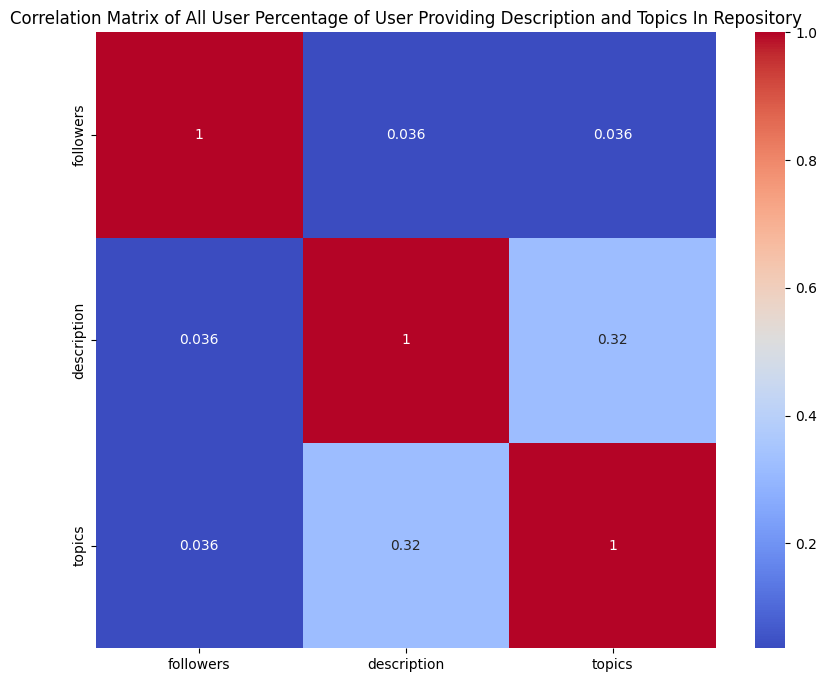

In [50]:
corr = plot_corr(select_numeric_column(merged_data), title='Correlation Matrix of All User Percentage of User Providing Description and Topics In Repository')

In [51]:
corr

,followers,description,topics
followers,1.000000,0.035683,0.035579
description,0.035683,1.000000,0.321376
topics,0.035579,0.321376,1.000000


By analyzing the correlation matrix, which encompasses the percentage of all users providing descriptions and topics, no significant correlation was found.

### Analyzing the correlation between numbers of star and forks, with the follower count for all users.

In [52]:
user_aggregates = repo_data.groupby('user_alias')[['stargazers_count', 'forks']].sum().reset_index()

In [53]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], user_aggregates, on='user_alias')

In [54]:
merged_data['user_type'] = ['high-follower user' if x > threshold else 'low-follower user' for x in merged_data['followers']]

In [55]:
merged_data.head()

,user_alias,followers,stargazers_count,forks,user_type
0,usr0,2.0,0.0,0.0,low-follower user
1,usr1,3.0,0.0,0.0,low-follower user
2,usr2,13.0,13.0,0.0,low-follower user
3,usr3,0.0,0.0,0.0,low-follower user
4,usr4,1.0,1.0,0.0,low-follower user


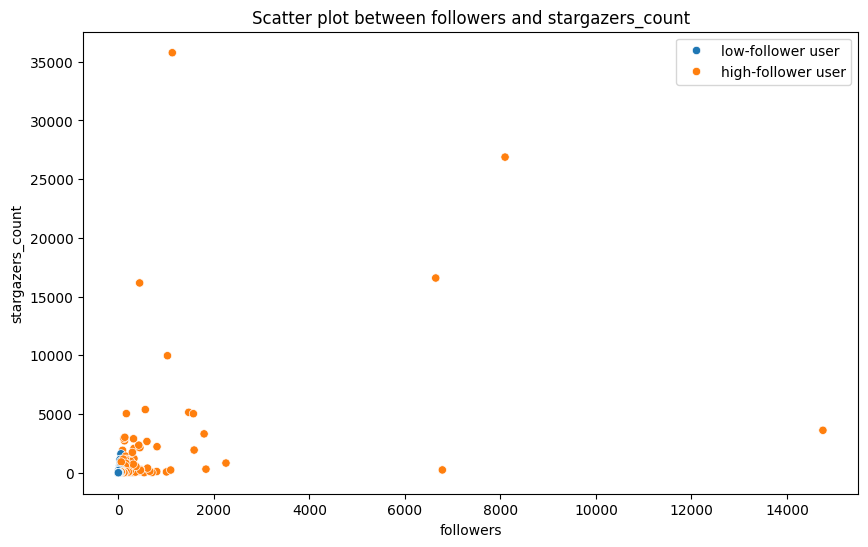

In [56]:
PlotScatter(df = merged_data, field_x = 'followers', field_y = 'stargazers_count', field_type = 'user_type', title = 'Scatter plot between followers and stargazers_count')

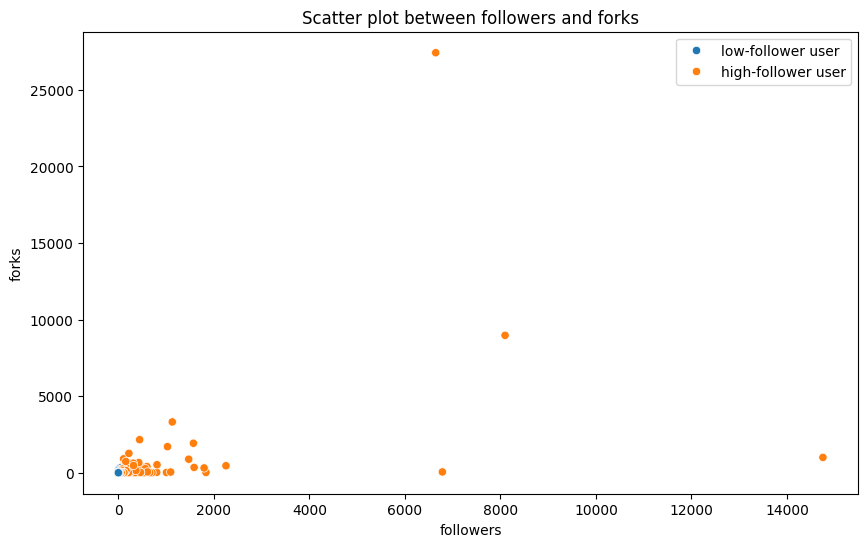

In [57]:
PlotScatter(df = merged_data, field_x = 'followers', field_y = 'forks', field_type = 'user_type', title = 'Scatter plot between followers and forks')

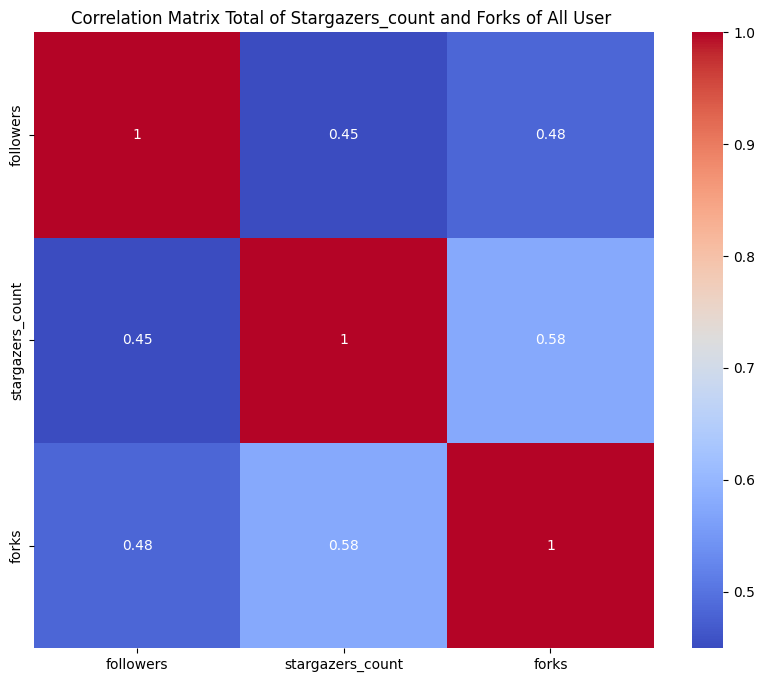

In [58]:
corr = plot_corr(select_numeric_column(merged_data), title='Correlation Matrix Total of Stargazers_count and Forks of All User ')

In [59]:
corr

,followers,stargazers_count,forks
followers,1.000000,0.449315,0.483359
stargazers_count,0.449315,1.000000,0.577439
forks,0.483359,0.577439,1.000000


In [60]:
results = regression_analysis(X = merged_data['stargazers_count'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     2141.
Date:                Mon, 05 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:13:42   Log-Likelihood:                -56679.
No. Observations:                8465   AIC:                         1.134e+05
Df Residuals:                    8463   BIC:                         1.134e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               11.1116      2.131      5.214      0.000       6.934      15.289
stargazers_count     0.1689      0.004     46.268      0.000       0.162       0.176
==============================================================================
Omnibus:                    26568.056   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4213335764.518
Skew:                          49.148   Prob(JB):                         0.00
Kurtosis:                    3457.852   Cond. No.                         585.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
results.pvalues['stargazers_count']

0.0

the p-value for `stargazers_count` is 0.00, which is less than 0.05. Therefore, the assumption that the amount of `stargazers_count` have an effects on users' follower count is statistically supported.

for each star in total `stargazers_count` that someone have in all of their repositories, their followers will increase by about 0.17.

In [62]:
results = regression_analysis(X = merged_data['forks'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     2580.
Date:                Mon, 05 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:13:42   Log-Likelihood:                -56507.
No. Observations:                8465   AIC:                         1.130e+05
Df Residuals:                    8463   BIC:                         1.130e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3468      2.086      6.398      0.000       9.258      17.436
forks          0.3311      0.007     50.794      0.000       0.318       0.344
==============================================================================
Omnibus:                    28087.232   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       5669543089.860
Skew:                          57.738   Prob(JB):                         0.00
Kurtosis:                    4010.615   Cond. No.                         320.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
results.pvalues['forks']

0.0

the p-value for `forks` is 0.00, which is also less than 0.05. Therefore, the assumption that the amount of `forks` have an effects on users' follower count is statistically supported.

for each fork in total `forks` that someone have in all of their repositories, their followers will increase by about 0.33.

### Analyzing the percentage of each language with follower count for high-follower user and low-follower user.

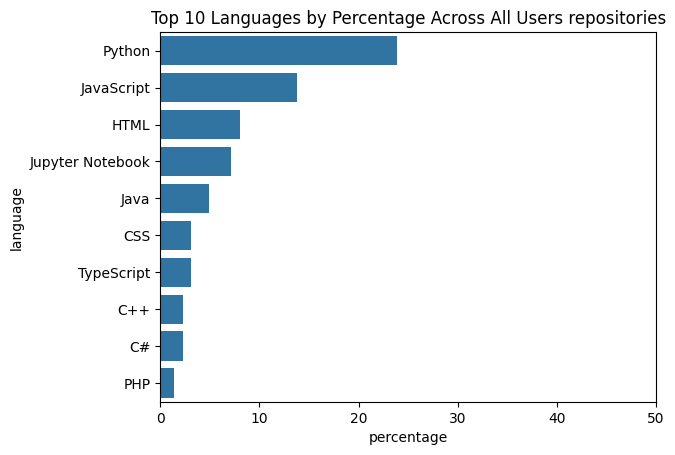

In [89]:
PlotTop10LanguagePercentage(repo_data, title = 'Top 10 Languages by Percentage Across All Users repositories', xlim=50)

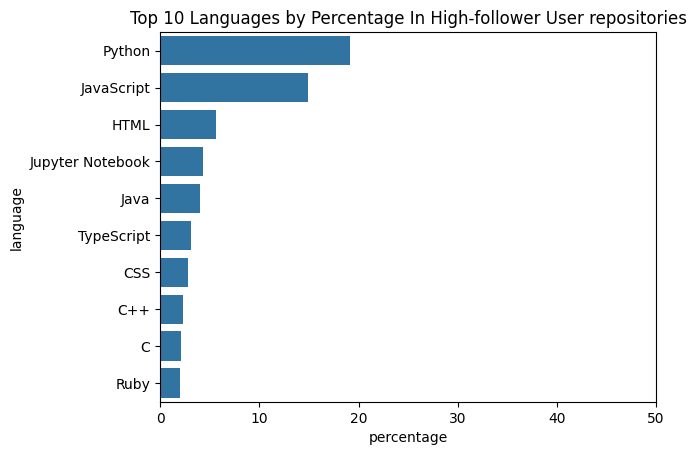

In [65]:
PlotTop10LanguagePercentage(high_follower_repo_data, title = 'Top 10 Languages by Percentage In High-follower User repositories', xlim=50)

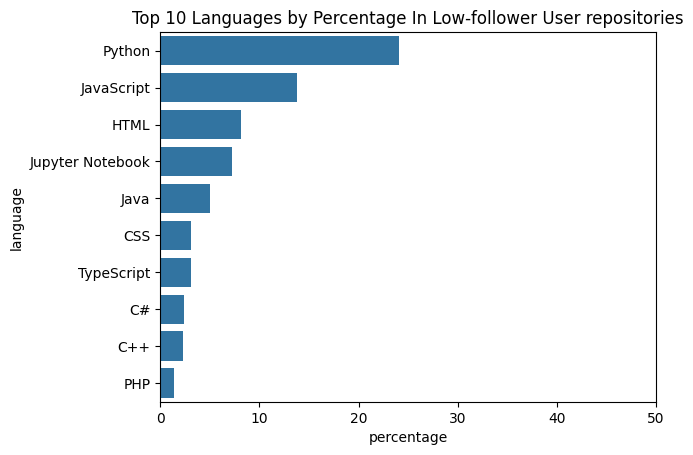

In [66]:
PlotTop10LanguagePercentage(low_follower_repo_data, title = 'Top 10 Languages by Percentage In Low-follower User repositories', xlim=50)

By analyzing the top 10 languages by percentage across all users, high-follower users, and low-follower users, it’s evident that the distribution of language usage is remarkably consistent across all three categories.

### Starred Data

In [67]:
starred_data.head()

,user_alias,full_name,html_url,description,language,topics,stargazers_count
0,usr1,microsoft/PowerToys,https://github.com/microsoft/PowerToys,Windows system utilities to maximize productivity,C#,color-picker/desktop/fancyzones/keyboard-manag...,101541.0
1,usr1,spring-projects/spring-security,https://github.com/spring-projects/spring-secu...,Spring Security,Java,framework/java/security/spring/spring-framework,8207.0
2,usr1,bitwarden/clients,https://github.com/bitwarden/clients,Bitwarden client applications (web/browser ext...,TypeScript,angular/bitwarden/browser-extension/chrome/cli...,7824.0
3,usr1,gothinkster/realworld,https://github.com/gothinkster/realworld,"""The mother of all demo apps"" — Exemplary full...",TypeScript,NaN,77396.0
4,usr1,ch4mpy/spring-addons,https://github.com/ch4mpy/spring-addons,Ease spring OAuth2 resource-servers configurat...,Java,auth0/cognito/hacktoberfest/keycloak/oidc/open...,405.0


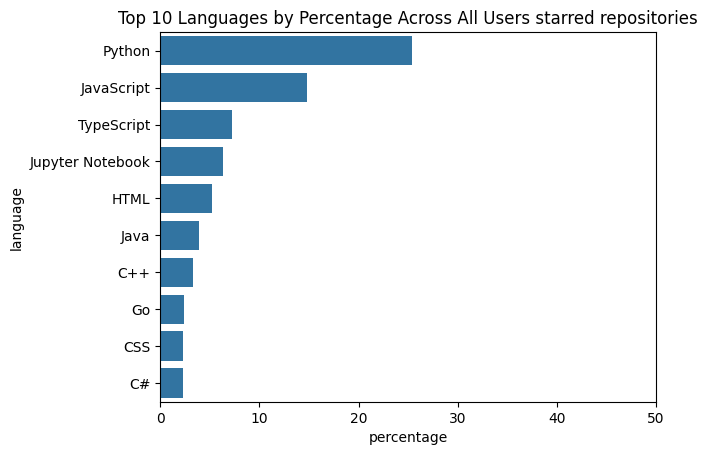

In [68]:
PlotTop10LanguagePercentage(starred_data, title = 'Top 10 Languages by Percentage Across All Users starred repositories', xlim=50)

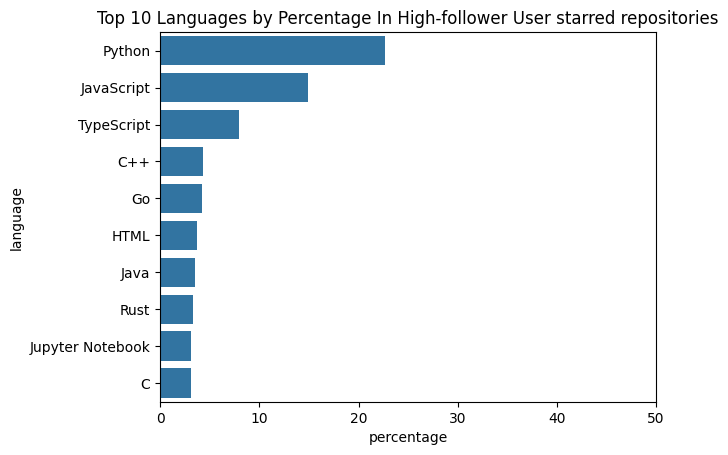

In [69]:
PlotTop10LanguagePercentage(high_follower_starred_data, title = 'Top 10 Languages by Percentage In High-follower User starred repositories', xlim=50)

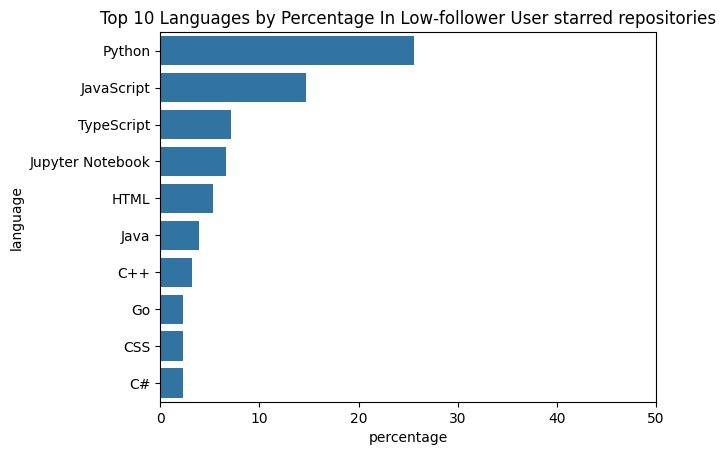

In [70]:
PlotTop10LanguagePercentage(low_follower_starred_data, title = 'Top 10 Languages by Percentage In Low-follower User starred repositories', xlim=50)

It’s clear that there are differences in the programming languages starred by high-follower and low-follower users like `Jupyter Notebook`, `HTML`, `Java`, `C++`, etc.

`Python`, `JavaScript`, and `TypeScript` are consistently the top three most popular languages across all users, high-follower users, and low-follower users.

In [71]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], starred_data, on='user_alias')

In [72]:
merged_data = merged_data[['user_alias', 'followers', 'language']]

In [73]:
merged_data = merged_data.groupby(['user_alias', 'followers', 'language']).size().unstack(fill_value=0)

In [74]:
total = merged_data.sum(axis=1)
transformed_data = merged_data.div(total, axis=0)
transformed_data.reset_index(inplace=True)

In [75]:
transformed_data.head()

language,user_alias,followers,1C Enterprise,AGS Script,ANTLR,ASL,ASP,ASP.NET,ActionScript,Ada,...,YAML,YARA,Yacc,ZenScript,Zig,hoon,kvlang,reStructuredText,sed,wdl
0,usr1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,usr10,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.010309,0.0,0.0,0.0,0.0,0.0
2,usr1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,usr1004,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,usr1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [76]:
language_to_check = ('Jupyter Notebook', 'HTML', 'Java', 'C++', 'C', 'C#', 'CSS', 'Go', 'Rust')

In [77]:
significant_result = []

for language in language_to_check:
    X = transformed_data[language]
    y = transformed_data['followers']
    results = regression_analysis(X, y)
    
    if results.pvalues[language] < 0.05:
        significant_result.append((language, results))

In [78]:
len(significant_result)

1

In [79]:
significant_result[0]

('Go',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1d6715062f0>)

In [80]:
significant_result[0][1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.784
Date:                Mon, 05 Feb 2024   Prob (F-statistic):            0.00922
Time:                        20:13:47   Log-Likelihood:                -36414.
No. Observations:                5163   AIC:                         7.283e+04
Df Residuals:                    5161   BIC:                         7.285e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.2239      4.042      5.745      0.000      15.299      31.148
Go           101.7847     39.078      2.605      0.009      25.175     178.394
==============================================================================
Omnibus:                    14818.438   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        656889110.115
Skew:                          38.497   Prob(JB):                         0.00
Kurtosis:                    1748.736   Cond. No.                         10.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
significant_result[0][1].pvalues['Go']

0.009223078522809822

the p-value for `Go` is 0.01, which is less than 0.05. Therefore, the assumption that the amount of a repository that user starred which used `Go` as a main language have an effects on users' follower count is statistically supported.

for each users' starred repository that used `Go` as a main language, their followers will increase by about 1.02.

In [82]:
user_aggregates = starred_data.groupby('user_alias')[['stargazers_count']].sum().reset_index()

In [83]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], user_aggregates, on='user_alias')

In [84]:
merged_data['user_type'] = ['high-follower user' if x > threshold else 'low-follower user' for x in merged_data['followers']]

In [85]:
merged_data.head()

,user_alias,followers,stargazers_count,user_type
0,usr1,3.0,445051.0,low-follower user
1,usr5,0.0,257.0,low-follower user
2,usr6,1.0,76876.0,low-follower user
3,usr7,3.0,128402.0,low-follower user
4,usr10,126.0,2513974.0,high-follower user


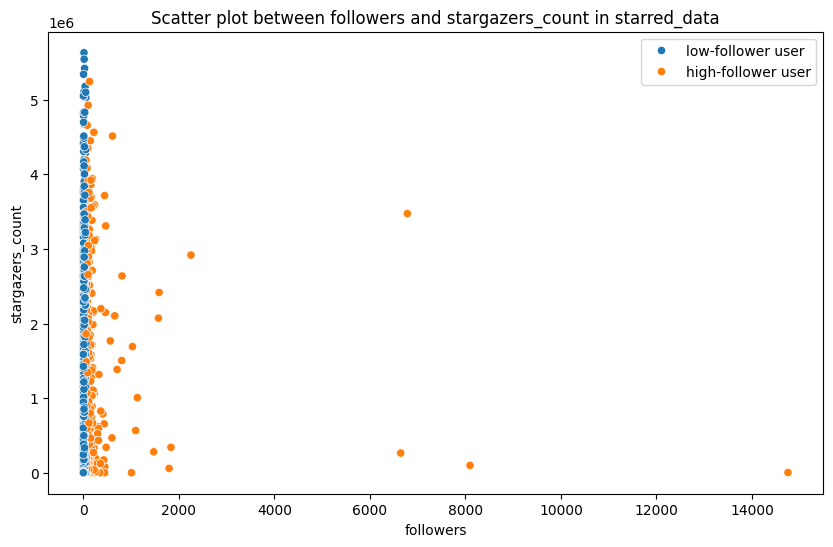

In [86]:
PlotScatter(df = merged_data, field_x = 'followers', field_y = 'stargazers_count', field_type = 'user_type', title = 'Scatter plot between followers and stargazers_count in starred_data')

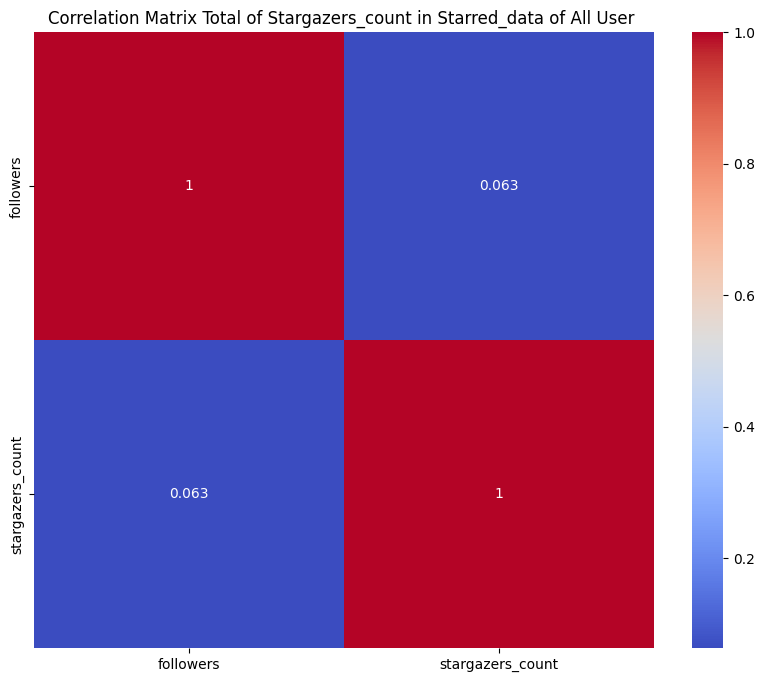

In [87]:
corr = plot_corr(select_numeric_column(merged_data), title='Correlation Matrix Total of Stargazers_count in Starred_data of All User ')

By analyzing the correlation matrix that includes the cumulative count of stargazers in starred data for all users, no significant correlation was found.

In [88]:
corr

,followers,stargazers_count
followers,1.000000,0.063393
stargazers_count,0.063393,1.000000
